Some weeks ago I stumbled across one paper in particular titled: _"Low-Resource” Text Classification: A Parameter-Free Classification Method with Compressors"_ [see @jiang2023low]. This paper has been dubbed the _"gzip paper"_, and has been largely discussed in the NLP community because of a refreshingly simple and efficient take on text classification. In the authors words they are matching neural networks in performance:

> There have been several studies in this field [@teahan2003using]; [@frank2000text], most of them based on the intuition that the minimum cross entropy between a document and a language model of a class built by a compressor indicates the class of the document. However, previous works fall short of matching the quality of neural networks.

## Some theory

As outlined in the quote above, one could regard text classification as a maximisation problem rather than a learning problem. This makes intuitive sense because of two reasons:

1. language usually follows a Zipf distribution [see @piantadosi2014zipf]
2. in a text classification problem different categories fall into different word registers

If we account for the fact that the top 10% of words are _common words_, it follows that there will be a number of distinct words and phrases which capture the _"gist"_ of every category. For this idea to work, we are taking it as given our categories are  distinct enough for a semantic differentiation.

For such datasets it appears unecessary to use a neural method, if all we truly want is to classify text.
Taking this intuition further, the authors formulate two properties of compression algorithms, and how they can be exploited for text classification:

1. compressors are good at capturing regularity
2. objects from the same category share more regularity than those from different categories

To this end they derive the _normalised compression distance_ from Bennet's information distance [see @681318] as follows:

$$NCD(x, y) = \frac{C(xy) - min\{C(x), C(y)\}}{max\{C(x), C(y)\}}$$

As the normalised compression distance is tractable, we can compute the distance matrix for a given dataset in $\mathcal{O}(n^2)$. This is mathematically elegant and simple, albeit not computationally efficient (it could be improved by employing caching on the compressor).

## Reproduction

The authors made reproduction easy for us because they kindly added a Python implementation. For the sake of this blogpost I adjusted the code and divided into [computation](distances.py) and analysis  step respectively. To reproduce the paper I decided to use the [20newsgroups](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) dataset also present in the paper. This is mainly for four reasons:

- it is available out of the box via `scikit-learn` which is convenient
- it is well-known and established benchmark dataset on a variety of tasks
- `20newsgroups` is a low-resource dataset (which is hard to begin with)
- the size of the dataset makes it feasible for me to compute on my local machine without much hassle

The first step after computation is evaluation, so we'll jump to that:

In [1]:
#| label: tbl-ncd-reproduction
#| tbl-cap: Classification report for normalised compressed distances on the 20newsgroups dataset

from IPython.display import display, HTML
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

dataset_train = fetch_20newsgroups(subset='train', random_state=123)
dataset_test = fetch_20newsgroups(subset='test', random_state=123)

compressed_train_set = np.load("20newsgroups.train.npy")
compressed_test_set = np.load("20newsgroups.test.npy")
ncd = np.load("20newsgroups.ncd.npy")

k = 2

y_pred = []

for index in range(len(ncd)):
    sorted_idx = np.argsort(ncd[index, :])
    top_k_class = dataset_train["target"][sorted_idx[:k]].tolist()
    predict_class = max(set(top_k_class), key=top_k_class.count)
    y_pred.append(predict_class)

ncd_report_df = pd.DataFrame(classification_report(dataset_test["target"], y_pred, target_names=dataset_test["target_names"], output_dict=True))
display(HTML(ncd_report_df.to_html()))

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc,accuracy,macro avg,weighted avg
precision,0.561404,0.313002,0.363071,0.338809,0.441860,0.612335,0.699552,0.835294,0.595782,0.506986,0.665049,0.633110,0.476190,0.630631,0.791667,0.945017,0.537313,0.706329,0.621622,0.559471,0.559081,0.591725,0.592931
recall,0.802508,0.501285,0.444162,0.420918,0.394805,0.351899,0.400000,0.358586,0.851759,0.639798,0.686717,0.714646,0.407125,0.353535,0.578680,0.690955,0.791209,0.742021,0.593548,0.505976,0.559081,0.561507,0.559081
f1-score,0.660645,0.385375,0.399543,0.375427,0.417010,0.446945,0.508972,0.501767,0.701138,0.565702,0.675709,0.671412,0.438957,0.453074,0.668622,0.798258,0.640000,0.723735,0.607261,0.531381,0.559081,0.558547,0.557414
support,319.000000,389.000000,394.000000,392.000000,385.000000,395.000000,390.000000,396.000000,398.000000,397.000000,399.000000,396.000000,393.000000,396.000000,394.000000,398.000000,364.000000,376.000000,310.000000,251.000000,0.559081,7532.000000,7532.000000


At `0.59` weighted average precision the algorithm significantly underperforms compared to the paper (reported with `0.685`). However, such artefacts are not uncommon, and there are a variety of factors (such as the operating system) which can affect compression. The results are in the same ballpark, and `0.59` precision is still fairly decent, given this is a pure computational approach to classifying 20 categories.

#### mode knn vs weighted

The default implementation of the paper uses `mode` to assign the class with the highest probability. This is odd in two ways.

Firstly it obscures the benchmark (why use a non-standard behaviour?). Secondly,it probably makes the benchmark harder, because often the weighted knn outperforms `mode`.

## Inspecting the normalised compression distance

Since the authors claim their distance is a normalised distribution one would like to make sure this claim is correct. Typically a plot helps.

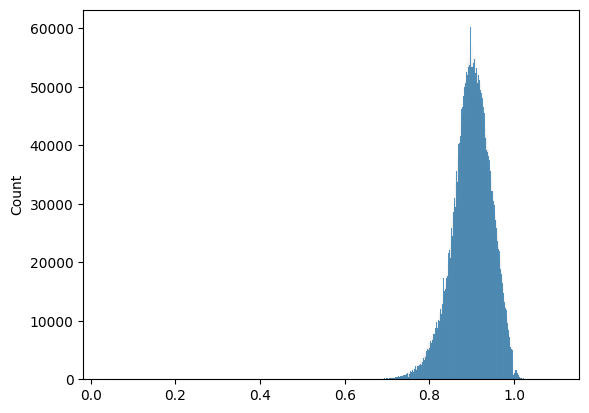

In [2]:
#| label: fig-ncd-histogram
#| fig-cap: "A histogram of normalised count distances"

idx = np.random.randint(len(ncd), size=1000)
sample = ncd[idx, :].flatten().tolist()
fig, ax = plt.subplots()
sns.histplot(sample, ax=ax)
plt.show()

It appears their claim is correct, but `normaltest` can help us eliminate any remaining doubts. 

In [3]:
#| label: tbl-normaltest
#| tbl-cap: Normaltest result for normalised compressed distance matrix
from scipy import stats

res = stats.normaltest(sample)
ncd_normaltest_df = pd.DataFrame([[res.statistic.tolist(), res.pvalue.tolist()]], columns=["statistic", "pvalue"])
display(HTML(ncd_normaltest_df.to_html(index=False)))

statistic,pvalue
767182.369619,0.0


Beyond doubt the _NCD_ is of a normal distribution. Our next step is inspecting the input data from which the _NCD_ is derived.

/var/folders/k6/hdzmrkf915d0twbr_qmhy9l00000gn/T/ipykernel_69344/1604665436.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(grid[0, 0])
/var/folders/k6/hdzmrkf915d0twbr_qmhy9l00000gn/T/ipykernel_69344/1604665436.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(grid[0, 1:])


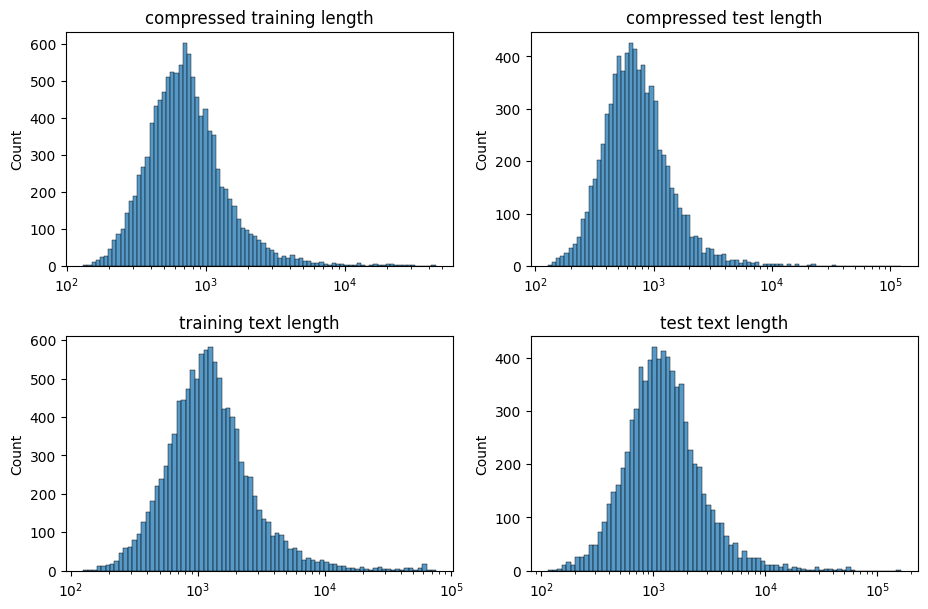

In [4]:
#| label: fig-compressed-length-vs-text-length
#| fig-cap: "Histograms of training and test lengths (un)compressed"

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(11, 7))

grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3)

ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1:])
ax3 = plt.subplot(grid[1, :1])
ax4 = plt.subplot(grid[1, 1:])

sns.histplot(compressed_train_set, log_scale=True, ax=ax1)
sns.histplot(compressed_test_set, log_scale=True, ax=ax2)
sns.histplot([len(x2) for x2 in dataset_train["data"]], log_scale=True, ax=ax3)
sns.histplot([len(x1) for x1 in dataset_test["data"]], log_scale=True, ax=ax4)

ax1.title.set_text("compressed training length")
ax2.title.set_text("compressed test length")
ax3.title.set_text("training text length")
ax4.title.set_text("test text length")

plt.show()

This finding may not be a surprise to everyone, but it is __highly__ interesting. If the _NCD_ is derived from the compressed length, and the text length is of the identical distribution as the compressed length, we should be able to simplify this model.

## Encoding linguistic knowledge into our model

Few things will sour linguists as much as researchers trying to build models (and algorithms), deliberately ignoring domain knowledge. In this sense, let's help with some insights from the linguistics department.

If the text length and compressed length are of the same distribution, the standard approach is to use a bag-of-word model. We could (computationally) simplify the NCD significantly. To do so:

1. build a simple `CountVectorizer` model
2. create a count matrix for the training and test data set
3. calculate the normalised count distance
4. reevaluate

Just as with the original paper, it is possible to split the code into [computation](distances_count.py) and analysis.
Using the computed count matrix, first we evaluate wether the count matrix and the original NCD are indeed of the same distribution.

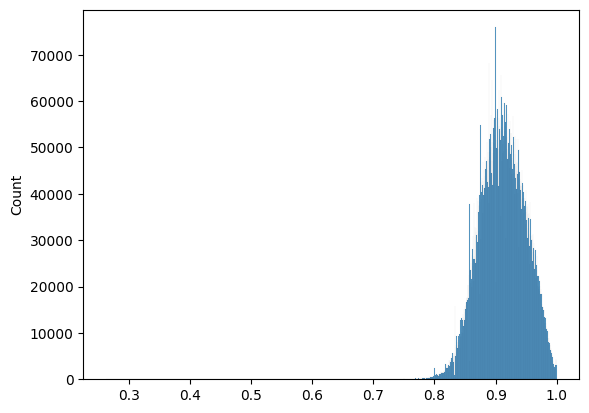

In [5]:
#| label: fig-histogram-count-matrix
#| fig-cap: "Histogram of normalised count distance"

count_matrix = np.load("20newsgroups.count_distances.npy")
idx_count = np.random.randint(len(count_matrix), size=1000)
sample_count = count_matrix[idx_count, :].flatten().tolist()

fig, ax = plt.subplots()
sns.histplot(sample_count, ax=ax)
plt.show()

Our intuition is spot on. This distribution plot is **very** similar to the one of the original NCD, to say the least. A [mood test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mood.html) can help us determine if the scales are indeed identical.

In [6]:
#| label: tbl-mood-test
#| tbl-cap: Mood test result for normalised compressed distance matrix and normalised count distance matrix

res = stats.mood(sample, sample_count)
ncd_mood_test_df = pd.DataFrame([[res.statistic.tolist(), res.pvalue.tolist()]], columns=["statistic", "pvalue"])
display(HTML(ncd_mood_test_df.to_html(index=False)))

statistic,pvalue
387.040639,0.0


Now that we can produce equivalent _NCD_ values from counts, we can reevaluate the original model.

In [7]:
#| label: tbl-count-report
#| tbl-cap: Classification report for normalised count distances on the 20newsgroups dataset
y_count_pred = []

for index in range(len(ncd)):
    sorted_idx = np.argsort(count_matrix[index, :])
    top_k_class = dataset_train["target"][sorted_idx[:k]].tolist()
    predict_class = max(set(top_k_class), key=top_k_class.count)
    y_count_pred.append(predict_class)

count_report_df = pd.DataFrame(classification_report(dataset_test["target"], y_count_pred, target_names=dataset_test["target_names"], output_dict=True))
display(HTML(count_report_df.to_html()))

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc,accuracy,macro avg,weighted avg
precision,0.408621,0.323248,0.363265,0.392202,0.418301,0.597633,0.796117,0.788462,0.497703,0.443015,0.626289,0.567227,0.390476,0.601852,0.807692,0.871795,0.462057,0.680217,0.546468,0.403704,0.505975,0.549317,0.554029
recall,0.742947,0.521851,0.451777,0.436224,0.332468,0.255696,0.420513,0.310606,0.816583,0.607053,0.609023,0.681818,0.312977,0.328283,0.479695,0.512563,0.752747,0.667553,0.474194,0.434263,0.505975,0.507442,0.505975
f1-score,0.527253,0.399213,0.402715,0.413043,0.370478,0.358156,0.550336,0.445652,0.618459,0.512221,0.617535,0.619266,0.347458,0.424837,0.601911,0.645570,0.572623,0.673826,0.507772,0.418426,0.505975,0.501337,0.502325
support,319.000000,389.000000,394.000000,392.000000,385.000000,395.000000,390.000000,396.000000,398.000000,397.000000,399.000000,396.000000,393.000000,396.000000,394.000000,398.000000,364.000000,376.000000,310.000000,251.000000,0.505975,7532.000000,7532.000000


With `0.55` weighted average precision we lost 4 points to the original NCD. Interestingly, the recall values for individual categories are _very_ similar.

## Interim result

We can build an approximately similar model to _NCD_ using `CountVectorizer`. However, our linguistic model has a few distinct advantages:

1. It is extremely fast (_NCD_ is computed in ~30 minutes on 8 threads, counts are computed in 5 minutes with 1 thread)
2. `CountVectorizer` can generalise better to unseen data because of the Zipfian law
3. We have yet to start with other domain tricks such as preprocessing, which will boost the result

That's fair enough, you say, but simply building out a model is not sufficient. 

One of the major points the authors of the gzip paper emphasize is _explainability_. While explainability in neural architectures is tricky at best, the _NCD_ is only _mathematically_ explainable. For us mere humans, we still don't know what this model actually encodes. That's where `CountVectorizer` can come to our rescue.

## What's our KNN actually predicting?

Turning back to the authors original idea, we can speculate that:

1. The most common words will be stripped by compression
2. There are low-frequency words associated with the different categories

To prove this, we can inspect the count vectorizer. First, we will take a look at the token distribution:

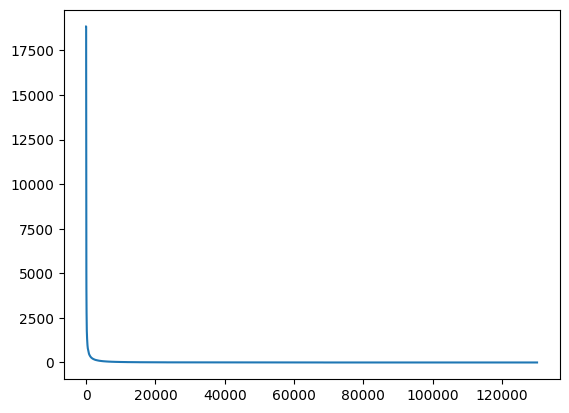

In [8]:
#| label: fig-histogram-token-frequency
#| fig-cap: "Histogram of token counts in 20newsgroup dataset"

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
train_dataset_count = vectorizer.fit_transform(dataset_train["data"])
test_dataset_count = vectorizer.transform(dataset_test["data"])

# nonzero indexes represents where data is actually stored
index_counter = Counter(train_dataset_count.nonzero()[1].tolist() + test_dataset_count.nonzero()[1].tolist())

fig, ax = plt.subplots()
sns.lineplot([count for idx, count in index_counter.most_common()], ax=ax)
plt.show()

Yep, that's a Zipfian distribution! If we discard the most common terms from this dataset, we can try and correlate it with our categories. To do so, we run the spearman correlation between the categories and the decomposition of the remaining matrix.

In [9]:
#| label: tbl-decomposition-correlation
#| tbl-cap: Spearman correlation coefficient for 1-D decomposition of the 20newsgroups dataset

from sklearn.decomposition import TruncatedSVD
offset = 10000
svd = TruncatedSVD(n_components=1, random_state=123)
X_embedded = svd.fit_transform(train_dataset_count[:, offset:])
res = stats.spearmanr(X_embedded, dataset_train["target"])

decomp_cor_df = pd.DataFrame([[res.statistic.tolist(), res.pvalue.tolist()]], columns=["statistic", "pvalue"])
display(HTML(decomp_cor_df.to_html(index=False)))

statistic,pvalue
0.264924,5.053535e-181


Would you look at this. A slight positive correlation with significance! With this knowledge at hand, we can note down how _NCD_ works.

If there are sufficient uncommon words per category, _NCD_ boosts the likelihood per category by maximising infrequent terms.

This approach may fall flat if categories consist of very similar words (such as is the case in humour detection).

## Closing remarks

Recently there has been a strong trend with the sentiment: _"neural architectures solves everything"_. In the light of this, I find it admirable to seek ways to efficiently model simple problems.

However, there is a decent amount of evidence showing that neural architectures are not the sole source of improvements in the field of NLP. 
Preprocessing is of particular importance to all kinds of models, notwithstanding neural architectures [see @levy-etal-2015-improving]. 

In this regard the _gzip paper_ falls short. Preprocessing isn't a tiresome step of modelling, it is actually our single best friend to combat sparseness.